Project report

Course: TKO_7093-3004 Statistical Data Analysis

Group: **052**

Group members:

* Niklas Aaltonen (nsaalt)

* Olli Ala-Hakula (otalha)

* Sergei Fedorov (sefedo)

Date of submission: 5.11.2025


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import scipy.stats as stats
import statsmodels.stats.weightstats as ssw
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preparation and description of the data


## Arranging the existing values

The variables are renamed to make them clear and readable. The ending `_num` means that the values of the variable is numeric as opposed to their categorical versions (will be added).

In [3]:
data = pd.read_csv('habits.data', sep = ';', index_col = False, header = 0, na_values = ['?'], skipinitialspace = True)
data = data.rename(columns = {
    'kohde' : 'household',
    'jasen' : 'member',
    'pvknro' : 'day',
    'sp' : 'sex_num',
    'ASALUE' : 'area_num',
    'IKAL1' : 'age_num',
    'A1' : 'work',
    'A2' : 'sleep',
    'A3' : 'read',
    'A4' : 'eat',
    'A5' : 'library_num'
})

In the following, values of variables `sex`, `area`, `age`, `day`, (reading in) `library` are brought to the categorical form. IDs are set as `int`.

In [4]:
# data types
## sex to m/f (categorical)
sex_map = {1.0 : 'm', 2.0 : 'f'}
sex_cat = data['sex_num'].map(sex_map)
data.insert(4, 'sex', sex_cat)
data['sex'] = data['sex'].astype('category')

## area to categorical
area_map = {1.0 : 'city', 2.0 : 'town', 3.0 : 'rural'}
area_cat = data['area_num'].map(area_map)
data.insert(6, 'area', area_cat)
data['area'] = data['area'].astype('category')

## age to categorical
age_map = [(data['age_num'] >= 10) & (data['age_num'] < 15),
           (data['age_num'] >= 15) & (data['age_num'] < 20),
           (data['age_num'] >= 20) & (data['age_num'] < 25),
           (data['age_num'] >= 25) & (data['age_num'] < 35),
           (data['age_num'] >= 35) & (data['age_num'] < 45),
           (data['age_num'] >= 45) & (data['age_num'] < 55),
           (data['age_num'] >= 55) & (data['age_num'] < 65),
           (data['age_num'] >= 65) & (data['age_num'] < 75),
           (data['age_num'] >= 75)]
age_cat = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# categories = ['10-14', '15-19', '20-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-']
data.insert(8, 'age_cat', np.select(age_map, age_cat, default = 0))   # mapping according to conditions
data['age_cat'] = pd.Categorical(data['age_cat'], ordered=True)

## library to categorical
lib_map = {1.0 : 'yes', 2.0 : 'no'}
lib_cat = data['library_num'].map(lib_map)
data.insert(14, 'library', lib_cat)
data['library'] = data['library'].astype('category')

## others
data['household'] = data['household'].astype(int)
data['member'] = data['member'].astype(int)
data['day'] = data['day'].astype('category')

# deleting old columns
data.drop(['sex_num', 'area_num', 'library_num'], axis = 1, inplace = True)

main_cols = ['household','day','sex','area','age_cat','work','sleep','read','eat','library']


In [5]:
display(pd.concat([data.iloc[0:7], data.iloc[43:47]], axis=0)[main_cols])

,household,day,sex,area,age_cat,work,sleep,read,eat,library
0,50002,1,m,city,6,0,560,0,80,yes
1,50002,2,m,city,6,380,450,10,0,yes
2,50003,1,f,town,5,0,470,30,100,yes
3,50003,2,f,town,5,0,550,0,0,yes
4,50004,1,m,city,7,640,410,0,0,yes
5,50004,2,m,city,7,0,550,72,108,yes
6,50005,1,f,city,6,0,540,40,NaN,no
43,50111,1,m,town,7,00:00,07:50,00:40,00:00,yes
44,50111,2,m,town,7,00:00,09:50,00:31,00:00,yes
45,50114,1,f,city,5,00:00,09:30,01:00,00:00,yes


Some of values in columns for the activity variables (except 'reading in library' which is categorical) are in hh:mm format instead of time in minutes. The following code converts the data in these columns to Int64 type.

In [6]:
def hhmm_to_m(x):       # replacing time hh:mm by time in minutes
  if pd.notna(x):
    if ':' in x:
      return int(int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
    elif float(x).is_integer:
      return int(x)
    else:
      return x
  else:
    return np.nan
data['work'] = data['work'].apply(hhmm_to_m).astype('Int64')
data['read'] = data['read'].apply(hhmm_to_m).astype('Int64')
data['sleep'] = data['sleep'].apply(hhmm_to_m).astype('Int64')
data['eat'] = data['eat'].apply(hhmm_to_m).astype('Int64')
                                        # Int64 is a nullable type
display(data.dtypes)
display(pd.concat([data.iloc[0:7], data.iloc[43:47]], axis=0)[main_cols])


,0
household,int64
member,int64
day,category
sex,category
area,category
age_num,int64
age_cat,category
work,Int64
sleep,Int64
read,Int64


,household,day,sex,area,age_cat,work,sleep,read,eat,library
0,50002,1,m,city,6,0,560,0,80,yes
1,50002,2,m,city,6,380,450,10,0,yes
2,50003,1,f,town,5,0,470,30,100,yes
3,50003,2,f,town,5,0,550,0,0,yes
4,50004,1,m,city,7,640,410,0,0,yes
5,50004,2,m,city,7,0,550,72,108,yes
6,50005,1,f,city,6,0,540,40,<NA>,no
43,50111,1,m,town,7,0,470,40,0,yes
44,50111,2,m,town,7,0,590,31,0,yes
45,50114,1,f,city,5,0,570,60,0,yes


In [7]:
# writing to a file
data.to_csv('habits_cleaned.csv', index = False, header = True, na_rep = '?')

## Overall characteristics of the data

The data consists of 6 demographic variables and 5 activity variables and represents a survey on habits of individual persons and households in Finland.


Here are the **demographic** variables along with the corresponding dataframe's column names, their types and possible values:

* **household ID** $\rightarrow$ `household` (type: integer)

* **member ID** (1 or 2) $\rightarrow$ `member` (type: integer)  [may be omitted]

* **day of week** $\rightarrow$ `day` (type: categorical)

  * `1` = working day

  * `2` = weekend

* **sex** (m = male, f = female) $\rightarrow$ `sex` (type: categorical)

* **age**

  * $\rightarrow$ `age_num` (type: integer)

  * $\rightarrow$ `age_cat` (type: categorical):

    * `1` = 10-14 years old

    * `2` = 15-19 years old
    
    * `3` = 20-24 years old
    
    * `4` = 25-34 years old
    
    * `5` = 35-44 years old
    
    * `6` = 45-54 years old
    
    * `7` = 55-64 years old
    
    * `8` = 65-74 years old
    
    * `9` = 75+ years old

* **living environment** $\rightarrow$ `area` (type: categorical)

  * `city` = city

  * `town` = municipality

  * `rural` = rural area

The **activity** variables were produced either by measuring the
number of minutes spent on the activity during the given day:

* **working** $\rightarrow$ `work` (type: integer)

* **sleeping** $\rightarrow$ `sleep` (type: integer)

* **reading** $\rightarrow$ `read` (type: integer)

* **dining at restaurant** $\rightarrow$ `eat` (type: integer)

or by recording whether the activity had been performed at least once within the past 12 months:

* **visiting library** $\rightarrow$ `library` (type: categorical)

  * `yes`

  * `no`

---


First, we consider the demographic variables, that is we look at what the surveyed group of people represents and under what conditions the survey was conducted.


In [8]:
data.describe(include='category')

,day,sex,area,age_cat,library
count,745,745,745,745,683
unique,2,2,3,7,2
top,1,f,city,7,yes
freq,377,387,472,183,474


The data consist of 745 records for the total of 378 households. Each household has at most 2 records.

In [9]:
print("The number of different households: ", data['household'].nunique())
print("The maximum number of occurrences of the same household: ", data['household'].value_counts().max())

The number of different households:  378
The maximum number of occurrences of the same household:  2


But any household has only one member.

In [10]:
data.groupby('household')['member'].nunique().max()

1

That means the majority of respondents gave their answers twice.
In fact, simple calculation provide a conclusion that 367 respondents gave they response twice and 11 ones replied once:
$367 \times 2 + 11 \times 1 = 745$.

In [11]:
data.groupby(['household', 'member']).size().max()

2

Moreover, if a person responded twice, one response was on a working day and another on weekend:

In [12]:
def diff_days_for_member(group):      # the condition that a person (group by person) respond twice in one day category
  return group['day'].nunique() < group['day'].count()
data.groupby(['household', 'member']).apply(diff_days_for_member, include_groups = False).sum().item()

0

In [13]:
# Demography data about unique respondents
demography_by_people = data.groupby(['household'], sort=False)[['sex', 'area', 'age_num', 'age_cat']].first()

resp_number = demography_by_people.shape[0]
demography_by_people

,sex,area,age_num,age_cat
household,,,,
50002,m,city,49,6
50003,f,town,41,5
50004,m,city,62,7
50005,f,city,46,6
50006,f,town,33,4
...,...,...,...,...
51971,f,rural,54,6
51973,m,town,41,5
51980,f,town,50,6


The distribution of the respondents by their residence area is the following (see the code below):

* `city` (urban area): 63.5%

* `town` (something in between): 15.3%

* `rural` (rural area): 21.2%

With a suitable definition of these concepts, the sample can be considered balanced with respect to this parameter.

[Tilastokeskus](pxdata.stat.fi/PxWeb/pxweb/en/StatFin/StatFin__vaerak/statfin_vaerak_pxt_11ra.px/table/tableViewLayout1/) provides the following figures for 2024:

* Share of persons in urban areas, %:	73.3

* Share of persons in rural areas, %:	25.3

including

* Share of persons in inner urban area, %:	38.6

* Share of persons in outer urban area, %:	24.1

* --

* Share of persons in peri-urban area, %:	10.6

* Share of persons in local centres in rural areas, %:	5.3

* --

* Share of persons in rural areas close to urban areas, %:	6.7

* Share of persons in rural heartland areas, %:	8.7

* Share of persons in sparsely populated rural areas, %:	4.5

In [14]:
demography_by_people['area'].value_counts() / resp_number

,count
area,
city,0.634921
rural,0.211640
town,0.153439


The gender distribution also looks pretty balanced, with a slight bias toward women, though.

Tilastokeskus, 2024: male 49.5%, female 50.5%

In [15]:
demography_by_people['sex'].value_counts() / resp_number

,count
sex,
f,0.518519
m,0.481481


Let's see whether the sample's age distribution matches population characteristics in Finland. The relative frequences of the age groups in the sample are as follows.

In [16]:
age_cat_freq = demography_by_people['age_cat'].value_counts() / resp_number    # frequencies of each age group wrt the total number of datapoints
age_cat_freq = age_cat_freq.loc[[3, 4, 5, 6, 7, 8, 9]]
display(age_cat_freq)

,count
age_cat,
3,0.031746
4,0.150794
5,0.169312
6,0.214286
7,0.246032
8,0.116402
9,0.071429


Compare this to the data provided by Tilastokeskus for the whole population.

In [17]:
age_stat = pd.read_csv('Tilastokeskus_age_distr_2024.txt', sep = '\t', header = 0)
age_stat = age_stat.T
age_stat.columns = ['%']
age_stat.drop(age_stat.index[0:4], inplace = True) # delete ages less than 20 (they are not in the sample)
age_stat_total = age_stat['%'].sum()  # the total of people aged 20+
print(age_stat_total)
age_stat = age_stat / age_stat_total   # percentage to the 20+ population of Finland
age_stat.head(20)

4494996


,%
20 - 24,0.069461
25 - 29,0.075601
30 - 34,0.085207
35 - 39,0.083231
40 - 44,0.083461
45 - 49,0.078618
50 - 54,0.070312
55 - 59,0.078333
60 - 64,0.080154
65 - 69,0.076480


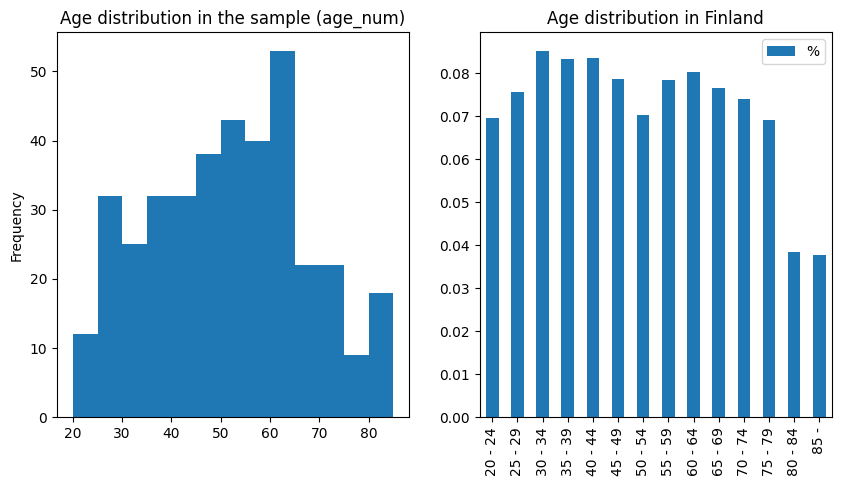

In [18]:
age_sample = demography_by_people['age_num']
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
age_sample.plot.hist(bins = list(range(20, 90, 5)), ax = axes[0])
axes[0].set_title('Age distribution in the sample (age_num)')
age_stat.plot.bar(ax = axes[1])
axes[1].set_title('Age distribution in Finland')
plt.show()

If we reorganize the population data into the age groups defined by the current research, we can see the discrepancies better and figure out the way it could be compensated. The fact that the most of persons entry in the dataset twice

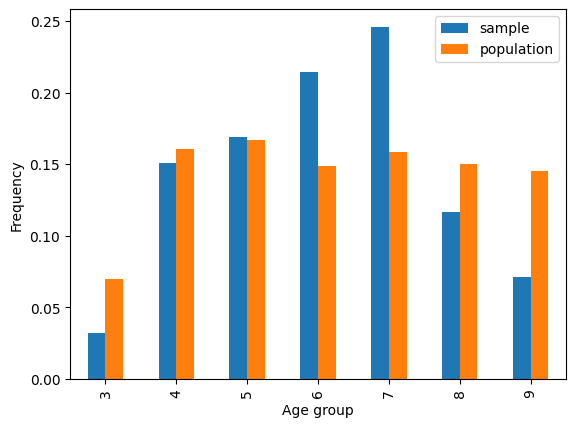

In [19]:
age_stat['group'] = [3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 9]
#age_stat['group'] = ['20 - 24', '25 - 34', '25 - 34', '35 - 44', '35 - 44', '45 - 54', '45 - 54', '55 - 64', '55 - 64', '65 - 74', '65 - 74', '75 -', '75 -', '75 -']
age_stat_cat = age_stat.groupby('group')['%'].sum()
age_compare = pd.concat([age_cat_freq, age_stat_cat], axis = 1)
age_compare.columns = ['sample', 'population']

ax = age_compare.plot.bar()
ax.set_xlabel('Age group')
ax.set_ylabel('Frequency')
plt.show()

As it can be seen from the plots, the sample's age distribution doesn't match the real age distribution at all. So, the sample is not balanced with respect to age and cannot be considered as a representative one.

To provide a reliable picture, we probably have to assign weights to the age categories.
The weight for an age category is calculated by dividing the real frequency of the category in the population by its frequency in the sample, so that the weighted frequency would be equal to the real one:
$$freq_{sample} \cdot weight = freq_{sample} \cdot \frac{freq_{real}}{freq_{sample}} = freq_{real}.$$

In [20]:
weights = age_compare['population'] / age_compare['sample']   # a Series with weights for age groups
display(weights)

data['weight'] = data['age_cat'].map(weights)   # adding a new column with weights based on age categories
data.head(12)

,0
3,2.188036
4,1.066408
5,0.984523
6,0.695007
7,0.644176
8,1.291955
9,2.033291


,household,member,day,sex,area,age_num,age_cat,work,sleep,read,eat,library,weight
0,50002,1,1,m,city,49,6,0,560,0,80,yes,0.695007
1,50002,1,2,m,city,49,6,380,450,10,0,yes,0.695007
2,50003,1,1,f,town,41,5,0,470,30,100,yes,0.984523
3,50003,1,2,f,town,41,5,0,550,0,0,yes,0.984523
4,50004,2,1,m,city,62,7,640,410,0,0,yes,0.644176
5,50004,2,2,m,city,62,7,0,550,72,108,yes,0.644176
6,50005,1,1,f,city,46,6,0,540,40,<NA>,no,0.695007
7,50005,1,2,f,city,46,6,0,550,52,108,no,0.695007
8,50006,1,1,f,town,33,4,0,540,0,90,yes,1.066408
9,50006,1,2,f,town,33,4,0,530,62,0,yes,1.066408


Another problem with the sample's balancedness (and with economics in general) is the proportion of supposedly unemployed individuals.
The number of instances with zero working time on working days is 265 which is about 70% of respondents while the declared unemployment rate is not yet this high in Finland. A clarification about data collection is needed. It could be assumed, though, that the survey was conducted during the holidays or at working time when employed people could not much participate. Still, at the point, the real reason is unknown.

In [21]:
data[(data['day'] == 1) & (data['work'] == 0)]['household'].size

263

On the other hand, on weekends the ratio of working and not working respondents is almost the same. There are 109 instances having positive working time on weekends.

In [22]:
data[(data['day'] == 2) & (data['work'] > 0)]['household'].size

109

It can be noticed that there are 69 respondents working only on weekend and 40 respondents working both on working day and weekend.

In [23]:
work_on_weekend = data[((data['day'] == 1) & (data['work'] == 0)) | ((data['day'] == 2) & (data['work'] > 0))].groupby('household')['day'].count()
print("Zero work on working day and positive work on weekend: ", work_on_weekend[work_on_weekend > 1].size)

work_always = data[((data['day'] == 1) & (data['work'] > 0)) | ((data['day'] == 2) & (data['work'] > 0))].groupby('household')['day'].count()
print("Positive work both on working day and on weekend: ", work_always[work_always > 1].size)


Zero work on working day and positive work on weekend:  69
Positive work both on working day and on weekend:  40


There are no duplicated datapoints in the dataset:

In [24]:
data.duplicated().sum().item()

0

If a person has two occurences, their parameters such as sex, living area, and age are the same, i.e. there is no incorrectness in this way.

In [25]:
member_groups = data.groupby(['household', 'member'])[['sex', 'area', 'age_num']].nunique().max(axis = 1)
member_groups[member_groups > 1].count().item()

0

In [26]:
display(data.groupby('area', observed=True)['sex'].value_counts(normalize=True))
display(data.groupby('age_cat', observed=True)['sex'].value_counts(normalize=True))


area   sex
city   f      0.519068
       m      0.480932
rural  f      0.500000
       m      0.500000
town   f      0.547826
       m      0.452174
Name: proportion, dtype: float64

age_cat  sex
3        f      0.500000
         m      0.500000
4        f      0.699115
         m      0.300885
5        f      0.540323
         m      0.459677
6        m      0.543210
         f      0.456790
7        m      0.508197
         f      0.491803
8        m      0.523256
         f      0.476744
9        m      0.547170
         f      0.452830
Name: proportion, dtype: float64

Here, we see significant disproportion of genders in some age categories. The greatest discrepancy is in age group 4 (25-34 year-olds): 70% female, 30% male. Also, in groups 6, 8, 9 there is a deviation of over 3 percentage points in male's favour.
It should be managed but it requires more detailed statistical data about Finland's population.

In [27]:
# Writing the table with weights to a file
data.to_csv('habits_with_weights.csv', index = False, header = True)

## Handling missing values

Only the activity variables have missing values.

In [28]:
data[:].isnull().sum()

,0
household,0
member,0
day,0
sex,0
area,0
age_num,0
age_cat,0
work,4
sleep,8
read,12


In [29]:
data[data['work'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
92,50239,1,m,city,8,<NA>,370,540,80,yes
279,50788,1,f,city,7,<NA>,450,10,90,yes
382,51075,2,m,rural,9,<NA>,635,247,0,NaN
672,51807,2,f,rural,5,<NA>,445,0,96,yes


In [30]:
data[data['sleep'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
187,50518,2,m,rural,6,70,<NA>,0,0,no
213,50591,2,m,city,6,0,<NA>,31,108,yes
328,50930,2,m,city,7,120,<NA>,124,0,yes
410,51146,2,f,city,4,0,<NA>,52,108,yes
452,51256,1,m,rural,4,0,<NA>,0,0,yes
456,51264,1,f,city,4,0,<NA>,0,0,no
503,51403,1,m,city,5,0,<NA>,0,0,no
697,51857,1,m,city,7,0,<NA>,0,0,yes


In [31]:
data[data['read'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
97,50242,2,m,city,7,0,470,<NA>,120,yes
149,50382,1,m,city,6,460,430,<NA>,0,NaN
191,50530,2,m,city,7,460,500,<NA>,0,NaN
237,50644,2,m,city,8,0,460,<NA>,132,yes
315,50883,1,f,city,9,0,640,<NA>,0,yes
320,50918,2,m,rural,9,0,675,<NA>,168,no
484,51364,1,f,rural,5,0,585,<NA>,0,yes
535,51464,1,m,city,3,0,660,<NA>,0,yes
706,51900,2,m,city,5,590,470,<NA>,96,no
707,51904,1,f,city,4,0,480,<NA>,0,yes


In [32]:
data[data['eat'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
6,50005,1,f,city,6,0,540,40,<NA>,no
12,50016,1,m,city,8,270,660,0,<NA>,no
420,51190,2,f,city,7,0,520,0,<NA>,yes
465,51284,2,f,city,8,0,540,93,<NA>,no
509,51408,1,f,rural,5,0,725,0,<NA>,yes
537,51466,1,f,city,4,460,470,50,<NA>,yes
548,51498,2,f,city,6,0,670,268,<NA>,yes
612,51667,1,f,town,5,460,470,0,<NA>,yes
674,51814,2,m,city,4,0,580,0,<NA>,NaN


It seems to be reasonable to fill in each missing value with the median of the corresponding variable's values in the group of respondents sharing the same day, sex, area, and age categories. In case of `library` it would be the mode (the most frequent value) in the group.

In [33]:
data_filled = data.copy()       # a copy of data that going to be free of NAs
for col in ['work', 'sleep', 'read', 'eat']:
  data_filled[col] = data[col].fillna(data.groupby(['day', 'sex', 'area', 'age_cat'], observed=True)[col].transform("median"))

data_filled['library'] = data['library'].fillna(
     data.groupby(['day', 'sex', 'area', 'age_cat'], observed=True)['library'].transform(lambda x: x.mode()[0] if not x.mode().empty else 'no'))


In [34]:
data_filled[:].isna().sum()

,0
household,0
member,0
day,0
sex,0
area,0
age_num,0
age_cat,0
work,0
sleep,0
read,0


The filled values are:

In [35]:
data_filled[data['work'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
92,50239,1,m,city,8,0,370,540,80,yes
279,50788,1,f,city,7,0,450,10,90,yes
382,51075,2,m,rural,9,0,635,247,0,no
672,51807,2,f,rural,5,0,445,0,96,yes


In [36]:
data_filled[data['sleep'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
187,50518,2,m,rural,6,70,555,0,0,no
213,50591,2,m,city,6,0,475,31,108,yes
328,50930,2,m,city,7,120,500,124,0,yes
410,51146,2,f,city,4,0,535,52,108,yes
452,51256,1,m,rural,4,0,345,0,0,yes
456,51264,1,f,city,4,0,500,0,0,no
503,51403,1,m,city,5,0,480,0,0,no
697,51857,1,m,city,7,0,510,0,0,yes


In [37]:
data_filled[data['read'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
97,50242,2,m,city,7,0,470,57,120,yes
149,50382,1,m,city,6,460,430,30,0,yes
191,50530,2,m,city,7,460,500,57,0,yes
237,50644,2,m,city,8,0,460,98,132,yes
315,50883,1,f,city,9,0,640,90,0,yes
320,50918,2,m,rural,9,0,675,196,168,no
484,51364,1,f,rural,5,0,585,5,0,yes
535,51464,1,m,city,3,0,660,20,0,yes
706,51900,2,m,city,5,590,470,41,96,no
707,51904,1,f,city,4,0,480,0,0,yes


In [38]:
data_filled[data['eat'].isna()][main_cols]

,household,day,sex,area,age_cat,work,sleep,read,eat,library
6,50005,1,f,city,6,0,540,40,70,no
12,50016,1,m,city,8,270,660,0,0,no
420,51190,2,f,city,7,0,520,0,0,yes
465,51284,2,f,city,8,0,540,93,0,no
509,51408,1,f,rural,5,0,725,0,0,yes
537,51466,1,f,city,4,460,470,50,70,yes
548,51498,2,f,city,6,0,670,268,0,yes
612,51667,1,f,town,5,460,470,0,90,yes
674,51814,2,m,city,4,0,580,0,90,yes


In [39]:
# Changing type of numerical columns to int
data_filled['work'] = data_filled['work'].astype(int)
data_filled['sleep'] = data_filled['sleep'].astype(int)
data_filled['read'] = data_filled['read'].astype(int)
data_filled['eat'] = data_filled['eat'].astype(int)
data_filled.dtypes

,0
household,int64
member,int64
day,category
sex,category
area,category
age_num,int64
age_cat,category
work,int64
sleep,int64
read,int64


In [40]:
#writing the filled-in table into a file
data_filled.to_csv('habits_filled.csv', index = False, header = True)

In [41]:
data = data_filled    # Let's hope we'll not need the initial data with NaNs

## Investigating correctness of collected data

Now, we look at the activity variables in order to find possible anomalies in them.

In [42]:
data.describe().round(2)

,household,member,age_num,work,sleep,read,eat
count,745.00,745.00,745.00,745.00,745.00,745.00,745.00
mean,51016.84,1.36,51.06,121.45,518.21,48.13,48.44
std,587.44,0.48,15.89,208.65,99.99,67.82,58.52
min,50002.00,1.00,20.00,0.00,70.00,0.00,0.00
25%,50518.00,1.00,39.00,0.00,460.00,0.00,0.00
50%,51053.00,1.00,52.00,0.00,510.00,30.00,0.00
75%,51524.00,2.00,63.00,200.00,580.00,70.00,100.00
max,51983.00,2.00,84.00,1050.00,900.00,608.00,240.00


array([[<Axes: xlabel='work', ylabel='work'>,
        <Axes: xlabel='sleep', ylabel='work'>,
        <Axes: xlabel='read', ylabel='work'>,
        <Axes: xlabel='eat', ylabel='work'>],
       [<Axes: xlabel='work', ylabel='sleep'>,
        <Axes: xlabel='sleep', ylabel='sleep'>,
        <Axes: xlabel='read', ylabel='sleep'>,
        <Axes: xlabel='eat', ylabel='sleep'>],
       [<Axes: xlabel='work', ylabel='read'>,
        <Axes: xlabel='sleep', ylabel='read'>,
        <Axes: xlabel='read', ylabel='read'>,
        <Axes: xlabel='eat', ylabel='read'>],
       [<Axes: xlabel='work', ylabel='eat'>,
        <Axes: xlabel='sleep', ylabel='eat'>,
        <Axes: xlabel='read', ylabel='eat'>,
        <Axes: xlabel='eat', ylabel='eat'>]], dtype=object)

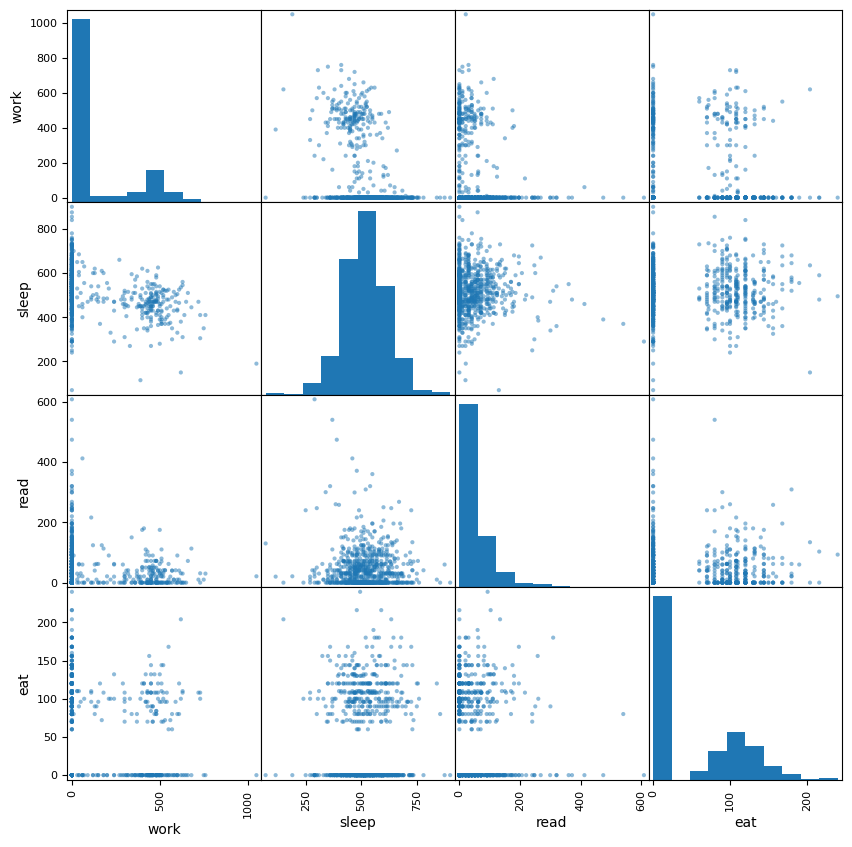

In [43]:
pd.plotting.scatter_matrix(data[['work', 'sleep', 'read', 'eat']], figsize=(10, 10))

In the figures, we can see that significant amount of values of all activity variables except sleeping are zero.

Other observations are:

* eating values tend to be discrete,

* those who read little, eat a lot (at restaurants).

Let's see what the zero values correspond to.

The proportions shown below should be compared with the frequences of corresponding categorical variables!

In [44]:
print("The fraction of zero values of 'work' variable: ",
 (data['work'] == 0).sum() / len(data))

# Proportions of zero work by week days
data[data['work'] == 0]['day'].value_counts(normalize=True)


The fraction of zero values of 'work' variable:  0.7033557046979866


,proportion
day,
1,0.505725
2,0.494275


In [45]:
# Proportions of zero work in areas
data[data['work'] == 0]['area'].value_counts(normalize=True)


,proportion
area,
city,0.652672
rural,0.208015
town,0.139313


In [46]:
# Proportions of zero work in age groups -- weighted
data[data['work'] == 0]['age_cat'].value_counts(normalize=True, sort=False) * weights


,0
age_cat,
3,0.070986
4,0.140424
5,0.140915
6,0.111413
7,0.181943
8,0.197245
9,0.197897


The figures look adequate.

In [47]:
print("The fraction of zero values of 'read' variable: ",
 (data['read'] == 0).sum() / len(data))

# Proportions of zero reading by week days
data[data['read'] == 0]['day'].value_counts(normalize=True)


The fraction of zero values of 'read' variable:  0.3516778523489933


,proportion
day,
1,0.515267
2,0.484733


In [48]:
# Proportions of zero reading in age groups
data[data['read'] == 0]['age_cat'].value_counts(normalize=True)


,proportion
age_cat,
4,0.270992
5,0.202290
6,0.198473
7,0.175573
8,0.068702
3,0.053435
9,0.030534


In [49]:
# Proportions of zero reading in areas
data[data['read'] == 0]['area'].value_counts(normalize=True)


,proportion
area,
city,0.591603
town,0.213740
rural,0.194656


The distribution of `read` variable's zero values looks rather natural. So, we can assume that this values are correct.

In [50]:
print("The fraction of zero values of 'eat' variable: ",
 (data['eat'] == 0).sum() / len(data))

# Proportions of zero eating (at restaurants) in age groups
data[data['eat'] == 0]['age_cat'].value_counts(normalize=True)


The fraction of zero values of 'eat' variable:  0.5651006711409396


,proportion
age_cat,
7,0.249406
6,0.223278
5,0.147268
4,0.140143
8,0.133017
9,0.078385
3,0.028504


In [51]:
# Proportions of zero eating (at restaurants) by week days
data[data['eat'] == 0]['day'].value_counts(normalize=True)

,proportion
day,
1,0.527316
2,0.472684


In [52]:
# Proportions of zero eating (at restaurants) in areas
data[data['eat'] == 0]['area'].value_counts(normalize=True)

,proportion
area,
city,0.622328
rural,0.216152
town,0.161520


As a conclusion, the zero values cannot be considered as mistakes or missing data.

Now, let's examine the values that are not zero but still too small or too large.

In [53]:
# Working
data[(data['work'] > 0) & (data['work'] < 30) | (data['work'] > 720)][['day', 'sex', 'area', 'age_num', 'work', 'sleep']]

,day,sex,area,age_num,work,sleep
75,2,f,city,26,730,410
212,1,m,city,46,760,410
404,2,f,city,44,1050,190
565,1,f,city,43,10,700
627,1,m,city,39,750,350
671,1,f,rural,44,730,305


Here, there are two respondents with highly different work time: 10 minutes and 17.5 hours on a day. Still, it is quite possible.

In [54]:
# Sleeping
data[(data['sleep'] < 60) | (data['sleep'] > 720)][['day', 'sex', 'area', 'age_num', 'work', 'sleep']]

,day,sex,area,age_num,work,sleep
67,2,m,rural,51,0,755
132,1,m,rural,47,0,855
133,2,m,rural,47,0,725
139,1,m,rural,46,0,875
203,2,f,rural,22,0,735
283,1,m,town,37,0,760
319,1,m,rural,77,0,735
334,2,m,city,54,0,730
354,2,f,city,20,0,730
381,1,m,rural,83,0,725


We can only be happy for people who sleep more than 12 hours a day and even record their sleep time with an accuracy of 5 minutes.

In [55]:
# Reading
data[(data['read'] > 0) & (data['read'] < 10) | (data['read'] > 720)][['day', 'sex', 'area', 'age_num', 'work', 'sleep', 'read', 'library']]

,day,sex,area,age_num,work,sleep,read,library
484,1,f,rural,35,0,585,5,yes


Actually, this particular value (5 minutes) was filled in by us earlier instead missing value as a median in a group the person belongs to.

In [56]:
# Eating at restaurant
data[(data['eat'] > 0) & (data['eat'] < 20) | (data['eat'] > 180)][['day', 'sex', 'area', 'age_num', 'eat']]

,day,sex,area,age_num,eat
195,2,m,rural,44,240
349,1,m,rural,58,190
445,2,m,city,60,216
459,2,m,rural,63,204
670,2,m,city,64,216
712,2,f,city,52,204


Quite possible. Values that are not rounded to the nearest 10 or at least 5 look a bit weird in this context.
Especially when given values of the variables look quite discrete: only 25 different values for 745 entries.
(33 persons ate at restaurants for 1 hour 48 minutes exactly! And these values were not added by us during the filling-in step.)




In [57]:
print("The number of unique 'eat' values: ", data['eat'].nunique())
data['eat'].value_counts()

The number of unique 'eat' values:  25


,count
eat,
0,421
120,49
108,33
96,32
90,28
100,28
80,23
144,19
70,16


Finally, let's check that the total time spent by an individual on daily activities is possible, i.e. it doesn't exceed, say, 22 hours.

In [58]:
data[data['work'] + data['eat'] + data['sleep'] + data['read'] > 22 * 60].size

0

We can conclude though that, as it could be seen from the previous, there are several outliers in the data but they don't seem to contradict anything and hence there is no solid reason to replace them.

# Analysis of the data

The goal of the data analysis is to determine
which activities people spend their time on and
whether there are differences between groups.

The questions to be answered are:

* How the individuals that participated in the survey as respondents could be characterised?

* What are the average estimations of time spent daily by Finnish households$^*$ on each of presented activity?

* With respect to which activities do living environments or days of week differ in Finland?

* Which activities are associated with each other in Finnish population?

$^*$ *It's worth noting that, as it was mentioned earlier, in the research we cannot make a difference between a household and an individual, because the data provide exactly one person in each household. At the same time, the majority of features under exploration are quite personal (like sleep or read time). So, it would be more correct to speak about individuals and not households.*

## Estimation for basic characteristics of population activities

In the following, we first look at such statistics as mean, quantiles, variance for individual activity variables and aim to get estimations for the population at whole.

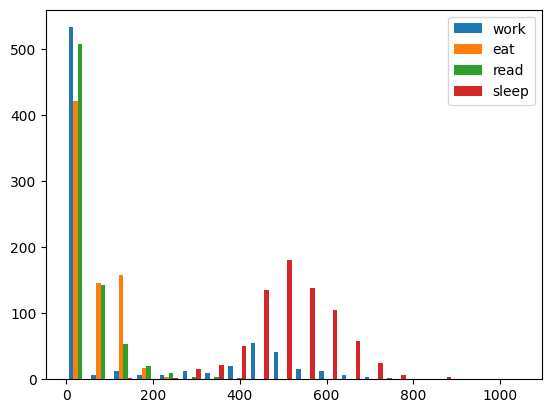

In [59]:
columns = ["work", "eat", "read", "sleep"]

plt.hist(x = data[columns], bins = 20, label = columns)
plt.legend(prop = {'size': 10})


From the histogram we can see that sleep is normally distributed with mean around 500 minutes. Other activities aren't symmetric and have mostly values at 0 minutes.

In [60]:
# testing normality: Shapiro--Wilk test's p-value
display(stats.shapiro(data[(data['day'] == 1) & (data['work'] > 0)]['work'])[1].item())
display(stats.shapiro(data[(data['day'] == 2) & (data['work'] > 0)]['work'])[1].item())
display(stats.shapiro(data[data['day'] == 1]['sleep'])[1].item())
display(stats.shapiro(data[data['day'] == 2]['sleep'])[1].item())
display(stats.shapiro(data[data['read'] > 0]['read'])[1].item())
display(stats.shapiro(data[data['eat'] > 0]['eat'])[1].item())


0.00016063789998370468

3.0130684982509656e-06

0.0002207920408400485

0.00081089763545989

2.1876490246162422e-27

2.5203002477399426e-10

The figures confirm our observation about unnormality of variables' distribution. But also indicate that working is not normal even if we consider separately working days and weekends and take into account only nonzero values.

In [61]:
data[["work", "sleep", "read", "eat"]].describe()

,work,sleep,read,eat
count,745.000000,745.000000,745.000000,745.000000
mean,121.449664,518.214765,48.131544,48.442953
std,208.649119,99.994124,67.820972,58.520764
min,0.000000,70.000000,0.000000,0.000000
25%,0.000000,460.000000,0.000000,0.000000
50%,0.000000,510.000000,30.000000,0.000000
75%,200.000000,580.000000,70.000000,100.000000
max,1050.000000,900.000000,608.000000,240.000000


As work, read and eat aren't symmetric it is more useful to use median to estimate individuals and as sleep seems to be normally distributed we can use mean. This would suggest that on average individual works 0 minutes, sleeps 510 minutes, reads 30 minutes and eats 0 minutes.

In addition to the table above, we calculate variance for those variables:

In [62]:
data[columns].aggregate(['mean', 'var']).round(2)

,work,eat,read,sleep
mean,121.45,48.44,48.13,518.21
var,43534.45,3424.68,4599.68,9998.82


These are calculated with $N - 1$ in the variance formula, hence they could be used as unbiased estimators.

Although the variables are not normally distributed, it is possible to estimate their means by the following method since the sample is large enough.

In [63]:
# confidence interval for the mean using the t-distribution
pd.DataFrame(ssw.DescrStatsW(data[columns]).tconfint_mean(),
            columns=columns,
            index=['lower', 'upper']).round(2)

,work,eat,read,sleep
lower,106.44,44.23,43.25,511.02
upper,136.46,52.65,53.01,525.41


This provide us with 95% confidence intervals the mean estimation for those four variables.

Let's see what information categorical variable `library` can provide.

In [64]:
data['library'].value_counts()

,count
library,
yes,531
no,214


In [65]:
print("Visiting library (answer on working day)")
display(data[data['day'] == 1]['library'].value_counts())
print("\nVisiting library (answer on weekend)")
display(data[data['day'] == 2]['library'].value_counts())

Visiting library (answer on working day)


,count
library,
yes,267
no,110



Visiting library (answer on weekend)


,count
library,
yes,264
no,104


Assuming that most people work only on week days and not on weekends, we can also check if individuals working activity is increased on week days

In [66]:
data[data['day'] == 1]["work"].describe()

,work
count,377.000000
mean,121.485411
std,208.482155
min,0.000000
25%,0.000000
50%,0.000000
75%,240.000000
max,760.000000


We can see that on week days median for working activity is still 0 minutes and mean almost the same. So there isn't any change compared to whole week'*s* working time.

However, if we exclude "unemployed" individuals (i.e. instances having zero working time on working days), the figures occur to be more realistic:

In [67]:
print("Work on working days")
print("Number of presumably unemployed respondents excluded: ",
      data[(data['day'] == 1) & (data['work'] == 0)]['household'].size)
data[(data['day'] == 1) & (data['work'] > 0)]['work'].describe()

Work on working days
Number of presumably unemployed respondents excluded:  265


,work
count,112.000000
mean,408.928571
std,169.202460
min,10.000000
25%,327.500000
50%,440.000000
75%,510.000000
max,760.000000


In [68]:
print("Work on weekend")
print("Number of 'not working' respondents excluded: ",
      data[(data['day'] == 2) & (data['work'] == 0)]['household'].size)
data[(data['day'] == 2) & (data['work'] > 0)]['work'].describe()

Work on weekend
Number of 'not working' respondents excluded:  259


,work
count,109.000000
mean,409.908257
std,170.969433
min,40.000000
25%,340.000000
50%,450.000000
75%,500.000000
max,1050.000000


Also, a confidence interval could be calculated for nonzero work.

In [69]:
positive_work = data[data['work'] > 0]  # instances with zero work are excluded
pd.DataFrame(ssw.DescrStatsW(positive_work['work']).tconfint_mean(),
            index=['lower', 'upper']).round(2)

,0
lower,386.92
upper,431.91


So, we can estimate that on average (meaning the median) an individual in the population works 0 minutes (or 7,5 hours for employed ones on working days), sleeps 8,5 hours, reads 30 minutes and eats at restaurant 0 minutes.

---



## Principal component analysis

<Axes: title={'center': 'day'}, xlabel='0', ylabel='1'>

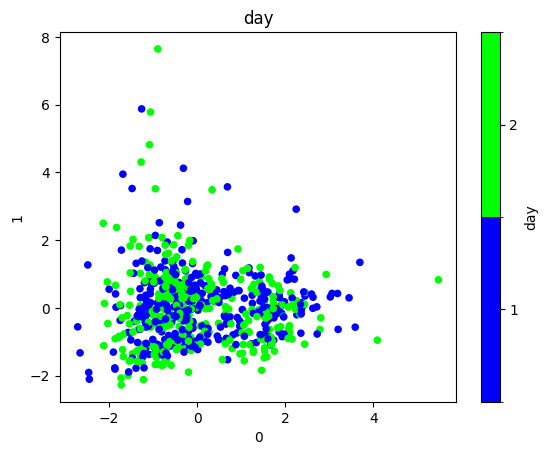

In [70]:
df = data[columns]

df_standardised = StandardScaler().fit_transform(df)

df_pca = pd.DataFrame(PCA().fit_transform(df_standardised))
df_extended = pd.concat([data, df_pca], axis=1)

df_extended.plot.scatter(0, 1, c='day', colormap='brg', title='day')

<Axes: title={'center': 'sex'}, xlabel='0', ylabel='1'>

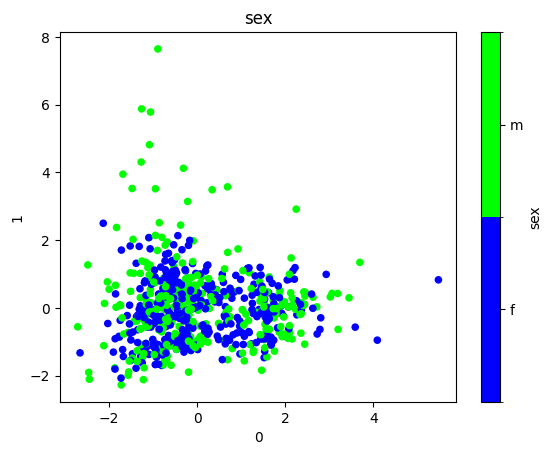

In [71]:
df_extended.plot.scatter(0, 1, c='sex', colormap='brg', title='sex')

<Axes: title={'center': 'area'}, xlabel='0', ylabel='1'>

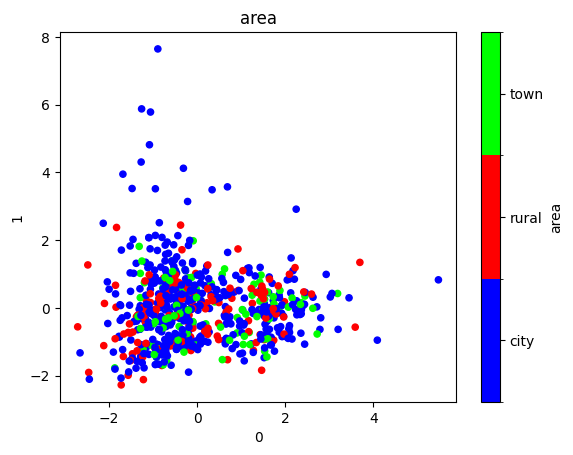

In [72]:
df_extended.plot.scatter(0, 1, c='area', colormap='brg', title='area')

<Axes: title={'center': 'age_cat'}, xlabel='0', ylabel='1'>

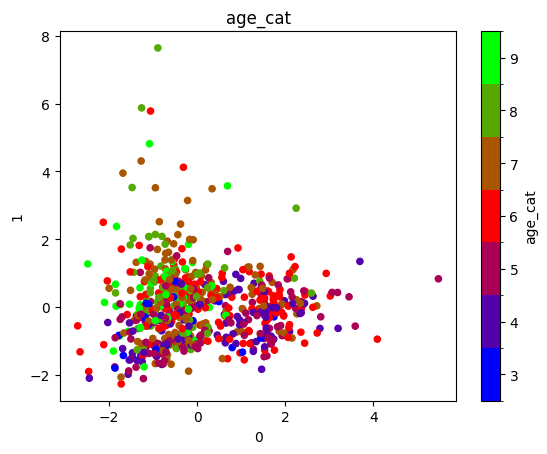

In [73]:
df_extended.plot.scatter(0, 1, c='age_cat', colormap='brg', title='age_cat')

<Axes: title={'center': 'library'}, xlabel='0', ylabel='1'>

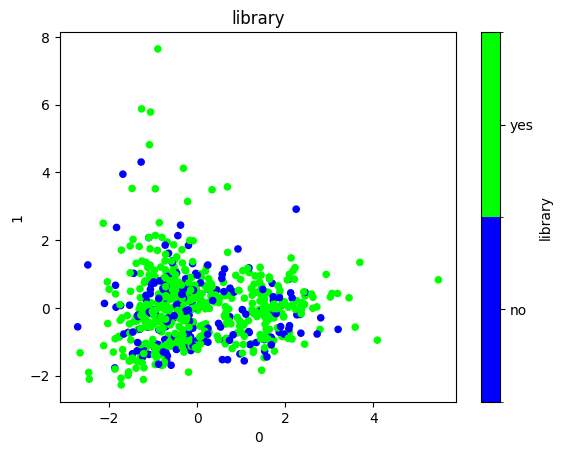

In [74]:
df_extended.plot.scatter(0, 1, c='library', colormap='brg', title='library')

From PCA analysis scatterplots we can't see clear clusters, but we can see few distinctions. For example males seem to have more variance compared to females who are more clustered. Same applies to city people who have more variance compared to rural and town individuals.

In [75]:
pca = PCA().fit(df_standardised)

pd.DataFrame(pca.components_, columns=df.columns)

,work,eat,read,sleep
0,0.718589,-0.069205,-0.243650,-0.647669
1,-0.087734,-0.531673,0.774290,-0.331815
2,-0.006316,0.844030,0.462612,-0.271227
3,0.689849,0.012199,0.356509,0.629968


Most important feature for component 1 is work and for component 2 it is read. Other variables have negative loadings in components 1 and 2.

## Statistical tests for pairs of variables

In this section, statistics comparing two variables are utilized.
Since none of numerical variables is normally distributed, only following tests are suitable:

* Spearman test for correlation of (paired) variables,

* Wilcoxon signed rank test for paired variables,

* Mann-Whitney U test for unpaired variables,

* $\chi^2$-test for categorical variables.

For the activity variables itselves only unpaired variants should be applied, because the variables have independent meaning. But if each of them is splitted into two value vectors, one for working days and one for weekends, being matched by individuals, these pairs could be subjected to testing by corresponding tests.

These could help answer questions on associations between the activities and on difference between various conditions with respect to the activities.


### Mann-Whitney U test

First, we run Mann-Whitney test for the numerical activity variables.
The null hypothesis $H_0$ is that two variables under consideration have the same probability distribution.

In [76]:
print("p-value from Mann-Whitney U test")
print("for 'work' and 'sleep':",
stats.mannwhitneyu(data['work'], data['sleep'], use_continuity=True, alternative='two-sided')[1].item())
print("for 'work' and 'read':",
stats.mannwhitneyu(data['work'], data['read'], use_continuity=True, alternative='two-sided')[1].item())
print("for 'work' and 'eat':",
stats.mannwhitneyu(data['work'], data['eat'], use_continuity=True, alternative='two-sided')[1].item())
print("for 'sleep' and 'read':",
stats.mannwhitneyu(data['sleep'], data['read'], use_continuity=True, alternative='two-sided')[1].item())
print("for 'sleep' and 'eat':",
stats.mannwhitneyu(data['sleep'], data['eat'], use_continuity=True, alternative='two-sided')[1].item())
print("for 'read' and 'eat':",
stats.mannwhitneyu(data['read'], data['eat'], use_continuity=True, alternative='two-sided')[1].item())

p-value from Mann-Whitney U test
for 'work' and 'sleep': 1.2199982941797496e-176
for 'work' and 'read': 4.876825480565859e-11
for 'work' and 'eat': 0.22570515874150288
for 'sleep' and 'read': 6.269624848997496e-243
for 'sleep' and 'eat': 1.2196161867544855e-249
for 'read' and 'eat': 0.08389015931199903


### Spearman correlation test

Here, we look for any correlation between the numerical activity variables.

The null hypothesis is that there is no rank correlation between two variables.



In [77]:
print("Coefficient and p-value from Spearman test")
print(f"for 'work' and 'sleep': coefficient {stats.spearmanr(data['work'], data['sleep'])[0]}, p-value {stats.spearmanr(data['work'], data['sleep'])[1]}")
print(f"for 'work' and 'read': coefficient {stats.spearmanr(data['work'], data['read'])[0]}, p-value {stats.spearmanr(data['work'], data['read'])[1]}")
print(f"for 'work' and 'eat': coefficient {stats.spearmanr(data['work'], data['eat'])[0]}, p-value {stats.spearmanr(data['work'], data['eat'])[1]}")
print(f"for 'sleep' and 'read': coefficient {stats.spearmanr(data['sleep'], data['read'])[0]}, p-value {stats.spearmanr(data['sleep'], data['read'])[1]}")
print(f"for 'sleep' and 'eat': coefficient {stats.spearmanr(data['sleep'], data['eat'])[0]}, p-value {stats.spearmanr(data['sleep'], data['eat'])[1]}")
print(f"for 'read' and 'eat': coefficient {stats.spearmanr(data['read'], data['eat'])[0]}, p-value {stats.spearmanr(data['read'], data['eat'])[1]}")


Coefficient and p-value from Spearman test
for 'work' and 'sleep': coefficient -0.39187435494706035, p-value 9.352480111489514e-29
for 'work' and 'read': coefficient -0.18558337309896727, p-value 3.373051670609854e-07
for 'work' and 'eat': coefficient -0.016444386690548856, p-value 0.6540658512355613
for 'sleep' and 'read': coefficient 0.011104676267731546, p-value 0.7621954327024926
for 'sleep' and 'eat': coefficient 0.01757901534927002, p-value 0.631906559484321
for 'read' and 'eat': coefficient -0.04253635355853804, p-value 0.24621502281727642


We are also able to test correlation of activity variables with the numerical age data of individuals.

In [78]:
print("Coefficient and p-value from Spearman test")
print(f"for 'work' and 'age_num': coefficient {stats.spearmanr(data['work'], data['age_num'])[0]}, p-value {stats.spearmanr(data['work'], data['age_num'])[1]}")
print(f"for 'sleep' and 'age_num': coefficient {stats.spearmanr(data['sleep'], data['age_num'])[0]}, p-value {stats.spearmanr(data['sleep'], data['age_num'])[1]}")
print(f"for 'read' and 'age_num': coefficient {stats.spearmanr(data['read'], data['age_num'])[0]}, p-value {stats.spearmanr(data['read'], data['age_num'])[1]}")
print(f"for 'eat' and 'age_num': coefficient {stats.spearmanr(data['eat'], data['age_num'])[0]}, p-value {stats.spearmanr(data['eat'], data['age_num'])[1]}")


Coefficient and p-value from Spearman test
for 'work' and 'age_num': coefficient -0.256513417587532, p-value 1.16904770272606e-12
for 'sleep' and 'age_num': coefficient 0.0017355061632207101, p-value 0.962281624899267
for 'read' and 'age_num': coefficient 0.37576943284526093, p-value 2.1295718359196573e-26
for 'eat' and 'age_num': coefficient -0.0591083988275273, p-value 0.10695195133986159


###  $\chi^2$-test

The null hypothesis: two variables are independent.

We can compare `library` variable with categorical demographic variables. There is a reason to do it for `age_cat`, `area` and `sex` which are relatively constant for an individual within a year.



In [79]:
work_cat = (data['work'] > 0).value_counts()   # boolean Series: had work on this day / had no work on this day

library_vc = data['library'].value_counts()
sex_vc = data['sex'].value_counts()
day_vc = data['day'].value_counts()
age_cat_vc = data['age_cat'].value_counts()
age_cat_library_crosstab = pd.crosstab(data['age_cat'], data['library'])
area_library_crosstab = pd.crosstab(data['area'], data['library'])

print("p-value from chi-squared test")
print("for gender and visiting library: ", stats.chi2_contingency([sex_vc, library_vc])[1])
print("for age group and visiting library: ", stats.chi2_contingency(age_cat_library_crosstab)[1])
print("for area and visiting library: ", stats.chi2_contingency(area_library_crosstab)[1])



p-value from chi-squared test
for gender and visiting library:  2.58728895947955e-14
for age group and visiting library:  3.508058444362394e-13
for area and visiting library:  0.0033816327654646117


Also, we can consider numerical variables as categorical having splitted their values to bins.

In [80]:
work_bin = pd.cut(data['work'], bins = 15)
work_library_crosstab = pd.crosstab(work_bin, data['library'])
read_bin = pd.cut(data['read'], bins = 22)
read_library_crosstab = pd.crosstab(read_bin, data['library'])
eat_bin = pd.cut(data['eat'], bins = 8)
eat_library_crosstab = pd.crosstab(eat_bin, data['library'])

print("p-value from chi-squared test")
print("for area and visiting library: ", stats.chi2_contingency(work_library_crosstab)[1])
print("for area and visiting library: ", stats.chi2_contingency(read_library_crosstab)[1])
print("for area and visiting library: ", stats.chi2_contingency(eat_library_crosstab)[1])



p-value from chi-squared test
for area and visiting library:  0.7936810611492999
for area and visiting library:  0.5719782341680777
for area and visiting library:  0.5743760975554308


### Wilcoxon signed-rank test

We can consider for each of the numerical activity variable its values on working days and these on weekends as separate pieces of data. In this case, it is possible to apply tests in order to examine change in the variable between working days and weekends.

The null hypothesis of Wilcoxon test is that there is no significant difference in the medians of the paired samples.

In [81]:
work_days = data[data['day'] == 1]
weekends = data[data['day'] == 2]
separ_day = pd.merge(work_days, weekends, on='household', how='inner', suffixes=('_workday', '_weekend'))


In [82]:
print("p-value from Wilcoxon test for variables' values on working day and on weekend")
print("for 'work': ", stats.wilcoxon(separ_day['work_workday'], separ_day['work_weekend'], correction=True)[1])
print("for 'sleep': ", stats.wilcoxon(separ_day['sleep_workday'], separ_day['sleep_weekend'], correction=True)[1])
print("for 'read': ", stats.wilcoxon(separ_day['read_workday'], separ_day['read_weekend'], correction=True)[1])
print("for 'eat': ", stats.wilcoxon(separ_day['eat_workday'], separ_day['eat_weekend'], correction=True)[1])


p-value from Wilcoxon test for variables' values on working day and on weekend
for 'work':  0.7704201787763314
for 'sleep':  0.7122077365931394
for 'read':  0.00860146616688287
for 'eat':  0.00012536810200760375


# Interpretation of results and conclusions

This report describes an observational study conducted on a sample of the population of Finland. The goal of the study was to provide insights regarding daily habits of the population.

The sample provides 745 datapoint containing data about 378 individuals (over 20 years old) and time spent by them on some basic activities per day. The majority of respondents (367) have given their response twice: regarding working days and weekends.

Since the conclusions about the whole population were supposed to base on the sample data, the quality of the latter should be analysed first of all. The analysis shows that while the data provided has quite enough of instances, values look pretty correct and only few of them are missing, the sample is imbalanced in the way its age distribution and employedness don't match the real one. Also gender distribution inside some age groups deviates from the real one.



The estimated preferences of the population in various activities are outlined below.

## Descriptive characteristics

### Work

Contrary to initial expectations, the working time does not increase significantly on working days. There is some unknown particularity about data collection that cause too high rate of instances with zero working time.
Moreover, the rate is almost same both on working days and weekends.
There is a noticeable portion of individuals working only on weekends and also of working all the week.

According to the data, people in the population would work about 2 hours a day on average (no matter whether it is working day or weekend). The mean value is in the interval 1 h 46 min to 2 h 16 min with the probability of 95%.

After excluding presumably unemployed individuals, work characteristics appear to be about 6 h 50 min of work per day on average with high probability being in range from 6 h 27 min to 7 h 12 min, while median is 7 h 20 min. But still, they don't differ much for working days and weekends.



### Sleeping

The median of sleep time for the sample is 8 h 30 min.
The estimation of the mean value for all population is 8 h 38 min with 95% confidence interval (8 h 31 min, 8 h 45 min).

### Reading

The median of reading time in the sample is 30 minutes.
The estimated mean of reading time in the population if 48 minutes with an accuracy of $\pm 5$ minutes (i.e. confidence interval 43 to 53 minutes).

### Visiting restaurants

The data collected for this parameter raises questions. The recorded time is too accurate (to one minute), and the available values appear to be discrete (only 25 different values for 745 records).

Whatever the case may be, the estimation for population mean time is 48 minutes with confidence interval 44 to 53 minutes.

### Visiting libraries

The respondents were asked whether this activity had been performed at least once within the past 12 months. It is not clear how to interpret the results keeping in mind that the majority of respondents answered twice.

Nevertheless, the data shows that, regardless of whether we consider both answers or only one, the number of respondents visiting library at least one time per year is 2,5 times greater than not visiting. The same estimation could be done for the population in general.

## Comparison

It could be expected that there is not much similarity between the activity variables.
Statistical tests confirm that they have significantly different distribution except for two pairs:

* work time and eating-at-restaurant time can not be considered significantly different, which is perhaps understandable: on the one hand who works needs nutrition, on the other hand working person can afford visiting restaurants (possibly, vising restaurants mostly had place during lunch break);

* reading time and eating-at-restaurant time can not be considered differently distributed as well, which is pretty surprising, as nothing seemingly links these two activities.  

Examining correlation between pairs of activity variables yeilds more expectable results.
Namely, there are no solid reasons to consider the variables to be correlated except for two pairs:

* work time and sleep time correlates negatively with a statistical significance;

* work time and read time correlates negatively with a statistical significance.

This is a completely clear association since work takes time away from small pleasures.

Comparison of the activity variables with age of individuals shows that
there is no statistically significant correlation between age and sleep time (which is against our expectation) and between age and time spent at restaurants (which is quite expectable).

Comparison of work time and read time with age using statistical tests suggest, on the contrary, that there is no statistically significant reason to consider these pairs of variables as uncorrelated indicates. So, there is an evidence in favour of their relationship, supporting common-sense expectations.
More precisely, we have statistically significant reason to assume that
* work time and age are negatively correlated,
* reading time and age are positively correlated.

There is one categorical variable among the activity variables, about visiting library. It's hard to deal with it due to its different nature. Whereas other variables refer to a specific day, this one concerns just a fact of an event during one year.

However it is possible to check its dependance on such individual's parameters as gender, age group, and living environment. For all three of them, there is an evident in favour of their dependency with visiting library. In other words, we can state a statictically significant link between age, gender, and living environment of an individual and their habit to visit library, which is quite expectable.

Also, this variable was compared to categorical version of other activity variables (which was splitted into bins). But tests didn't show any evidence of significant dependency between the variables.

Comparing data for the same attribute given on working day and on weekend provides the following insights.

* there is a statistically significant difference in read time and in visiting restaurants between observed days.

* there is a statistical evidence that work time doesn't change significantly between working days and weekends, and the same is true for sleep time.

While the first point is quite expectable due to the fact that the daily routine may varies significantly between working days and weekends, the second one is quite surprising. It could be presumed that on weekends people work less and rest (sleep) more. The results could the explained, though, by the observation that the data sample contains unproportionally many datapoints with zero work. So, we cannot make solid estimations linked to working only based on the given data.